# CQF Final Project: Pairs-Trading Strategy Design & Backtest (2025)

## Statistical Analysis and Threshold Optimization

This section performs the statistical tests and threshold optimization for the downloaded asset groups.

#### Statistical Tests: Hypotheses & Thresholds

| Test       | Null (H₀)                                | Alternative (H₁)          | α-Level |
|------------|------------------------------------------|---------------------------|---------|
| ADF        | Non-stationarity (unit root)            | Stationarity              | 5%      |
| KPSS       | Stationarity                            | Unit root                 | 5%      |
| EG Step 2  | No cointegration (β_ec=0)               | Cointegration (β_ec≠0)    | 5%      |
| Johansen   | ≤ r cointegration vectors               | > r cointegration vectors | 5%      |

See details in the ADF & KPSS and Engle–Granger sections below.

In [1]:
from datetime import datetime, timedelta

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Custom modules
from data_download import fetch_asset_data
import coint_tests
import backtest

from coint_tests import (
    summarize_cointegration_tests, run_pair_backtests, matrix_ols_regression, 
    select_var_order, engle_granger, engle_granger_bidirectional, multi_subperiod_stability_check,
    johansen, analyze_error_correction_model, ou_params, kalman_hedge, za_test,
    analyze_regression_var_summary, analyze_stability_across_classes, analyze_johansen_triples
)
from pair_selection_summary import assemble_group_summary
from backtest import (
    generate_pair_pnl, run_individual_pair_backtests, run_vol_targeted_backtests, 
    run_guarded_backtests, compute_pair_metrics
)
from plotting import plot_performance, analyze_pairs_nb, safe_metrics

In [2]:
# Configure pandas display options
pd.set_option('display.float_format', '{:.4f}'.format)
pd.set_option('display.precision', 4)
pd.set_option('display.float_format', lambda x: '{:.4f}'.format(x))

# Replace NaN with dashes in display - this affects string representation
pd.options.display.float_format = lambda x: '{:.4f}'.format(x) if pd.notna(x) else '-'

# Set string representation for NaN values
np.set_printoptions(formatter={'float': lambda x: '{:.4f}'.format(x) if not np.isnan(x) else '-'})

In [3]:
# Utility function to format DataFrames for display
def format_df_for_display(df):
    """Format DataFrame for display with 4 decimals max and dashes for NaN"""
    formatted_df = df.copy()
    for col in formatted_df.select_dtypes(include=[np.number]).columns:
        formatted_df[col] = formatted_df[col].apply(
            lambda x: f'{x:.4f}' if pd.notna(x) else '-'
        )
    return formatted_df

# Smart formatting function that handles integers vs floats
def smart_format_value(x):
    """Format numeric values intelligently: integers as whole numbers, floats with max 4 decimals"""
    if pd.isna(x):
        return '-'
    
    # Check if it's effectively an integer (no fractional part)
    if isinstance(x, (int, np.integer)) or (isinstance(x, (float, np.floating)) and x == int(x)):
        return f'{int(x)}'
    else:
        # For floats, use up to 4 decimals but remove trailing zeros
        formatted = f'{x:.4f}'.rstrip('0').rstrip('.')
        return formatted if formatted else '0'

# Monkey patch DataFrame._repr_html_ to use smart formatting
original_repr_html = pd.DataFrame._repr_html_

def custom_repr_html(self):
    try:
        # Apply smart formatting for numeric columns
        display_df = self.copy()
        for col in display_df.select_dtypes(include=[np.number]).columns:
            display_df[col] = display_df[col].apply(smart_format_value)
        return display_df.to_html(escape=False, na_rep='-')
    except:
        # Fallback to original if there's any error
        return original_repr_html(self)

pd.DataFrame._repr_html_ = custom_repr_html

**Pairs Selection Rationale**

- Motivation: test economically linked and liquid assets where mean-reversion is plausible.
- Diversity: include commodities, rates/FX, volatility, indices, equities, and sector ETFs.
- Focus: run tests across many candidates, then analyze top cointegrated contenders.

**Pair/Triple Summaries**

- **Precious Metals Triple (Gold, Silver, Platinum):** These metals often move together due to their roles as stores of value and industrial inputs, with cointegration potentially driven by macroeconomic cycles and investor sentiment.
- **Oil Pair (WTI, Brent):** WTI and Brent oil are global crude benchmarks whose price relationship reflects supply-demand dynamics, geopolitical events, and infrastructure changes.
- **Agri Pair (Corn, Soybean):** Corn and soybean prices are linked by crop rotation, weather patterns, and global trade flows, making them natural candidates for cointegration.
- **Yield Pair (US 10Y Yield, UK Gilts ETF):** US and UK government bond yields are influenced by global interest rate cycles and monetary policy, often showing correlated movements.
- **Currency Pair (AUD/USD, CAD/USD):** Both AUD and CAD are commodity-linked currencies, with their exchange rates shaped by similar macroeconomic and trade factors.
- **Volatility Pair (VIX, VIXY):** The VIX index and VIXY ETF track US equity volatility, with their relationship affected by futures curve dynamics and market stress regimes.
- **EU Index Pair 1 (CAC 40, DAX):** French and German equity indices are closely tied through European economic integration and cross-border corporate activity.
- **EU Index Pair 2 (IBEX 35, FTSE MIB):** Spanish and Italian indices reflect Southern European market conditions, often responding similarly to regional events.
- **FR Banking Pair (BNP Paribas, Societe Generale):** Two major French banks with overlapping business models and exposure to the same regulatory environment.
- **Fast Fashion Pair (Inditex, H&M):** Leading European fast fashion retailers, whose performance is shaped by consumer trends and global supply chains.
- **German Auto Triple (VW, Mercedes, BMW):** Germany’s top automakers, sharing industry cycles, regulatory changes, and technological shifts.
- **Investor AB Pair (Investor A, Investor B):** Two share classes of the same Swedish investment company, expected to track closely due to identical underlying assets but with different voting rights.
- **VW Porsche Pair (VW, Porsche AG):** Linked through ownership structure and shared automotive sector exposure.
- **Semiconductor Pair (ASML, Infineon):** European semiconductor firms, with cointegration possible due to sector wide demand and supply chain factors.
- **Sector ETF Pair (XLRE, XLU):** US real estate and utilities ETFs, both considered defensive sectors and often moving together during risk-off periods.


In [4]:
end_date   = datetime.now()
start_date = end_date - timedelta(days=5*365)

asset_groups = {
    # Commodities
    "precious_metals_triple": ["GC=F", "SI=F", "PL=F"],    # Gold, Silver, Platinum Futures
    "oil_pair": ["CL=F", "BZ=F"],                          # WTI, Brent Crude Futures
    "agri_pair": ["ZC=F", "ZS=F"],                         # Corn, Soybean Futures

    # Fixed Income & Currency
    "yield_pair": ["^TNX", "IGLT.L"],                      # US 10Y Yield, iShares UK Gilts ETF
    "currency_pair": ["AUDUSD=X", "CADUSD=X"],             # AUD/USD, CAD/USD

    # Volatility
    "volatility_pair": ["^VIX", "VIXY"],                   # US VIX Index vs. Short-Term VIX Futures ETF*

    # Country Indices
    "eu_index_pair_1": ["^FCHI", "^GDAXI"],                # CAC 40, DAX
    "eu_index_pair_2": ["^IBEX", "FTSEMIB.MI"],            # IBEX 35, FTSE MIB

    # Equities
    "fr_banking_pair": ["BNP.PA", "GLE.PA"],               # BNP Paribas, Societe Generale
    "fast_fashion_pair": ["ITX.MC", "HM-B.ST"],            # Inditex, H&M
    "german_auto_triple": ["VOW3.DE", "MBG.DE", "BMW.DE"], # VW, Mercedes, BMW
    "investor_ab_pair": ["INVE-A.ST", "INVE-B.ST"],        # Investor A, Investor B
    "vw_porsche_pair": ["VOW3.DE", "P911.DE"],             # VW, Porsche AG
    "semiconductor_pair": ["ASML.AS", "IFX.DE"],           # ASML, Infineon

    # ETFs
    "sector_etf_pair": ["XLRE", "XLU"]                     # Real Estate ETF, Utilities ETF
}

all_data = fetch_asset_data(asset_groups, start_date, end_date)

[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%********

**Data Exploration and Regression/VAR Diagnostics**

After downloading the series we can inspect the data and run simple regressions and VAR order selection.

For each pair we have (or for triples add columns accordingly):
$$
\mathbf{Pair} \,=\, 
\begin{pmatrix}
\vdots & \vdots & \vdots\\
y_{t} & x^{(1)}_{t} & x^{(2)}_{t}\\
\vdots & \vdots & \vdots
\end{pmatrix}
$$

$$
\mathbf{y} \,=\, \begin{pmatrix}y_1\\ \vdots\\ y_T\end{pmatrix} \in \mathbb R^{T\times1},\quad
\mathbf{X} \,=\, \begin{pmatrix}
1 & x^{(1)}_1 & x^{(2)}_1 & \cdots \\ 
\vdots & \vdots & \vdots & \\
1 & x^{(1)}_T & x^{(2)}_T & \cdots 
\end{pmatrix} \in \mathbb R^{T\times k}
$$

The first column of ones is the intercept; k is the number of regressors.

- Let y be the T×1 target vector and X the T×k design matrix (with intercept).
- OLS estimator and fitted values:
$$ 
\hat{\boldsymbol\beta}= (\mathbf{X}^\top \mathbf{X})^{-1}\,\mathbf{X}^\top\,\mathbf{y},\quad
\hat{\mathbf{y}}=\mathbf{X}\,\hat{\boldsymbol\beta},\quad 
\hat{\boldsymbol\varepsilon}=\mathbf{y}-\hat{\mathbf{y}}
$$
We use R^2 only as a crude co-movement indicator; cointegration must be tested explicitly.

- Why lags: capture dynamic dependence and avoid residual autocorrelation; too few lags bias inference, too many add noise.
- VAR(p) form for n series:
$$
\mathbf{Y}_t \,=\, A_1\,\mathbf{Y}_{t-1} + \cdots + A_p\,\mathbf{Y}_{t-p} + \mathbf{c} + \varepsilon_t
$$
- Include intercept c to absorb non-zero means; estimate by multivariate OLS.


To choose lag p, balance fit and parsimony for a VAR with log-likelihood \(\ell_p\) and parameters \(K=n^2p+n\):
$$
\begin{aligned}
\mathrm{AIC}(p) &= -2\,\ell_p + 2K,\\
\mathrm{BIC}(p) &= -2\,\ell_p + K\,\ln(T-p),\\
\mathrm{HQIC}(p) &= -2\,\ell_p + 2K\,\ln\!\big(\ln(T-p)\big).
\end{aligned}
$$

With optimal lag chosen, assess stability via the companion matrix:
$$
\mathcal{F} = \begin{pmatrix}
A_1 & A_2 & \cdots & A_{p-1} & A_p \\
I_n & 0   & \cdots & 0        & 0   \\
0   & I_n & \cdots & 0        & 0   \\
\vdots &   & \ddots &          & \vdots\\
0   & 0   & \cdots & I_n      & 0
\end{pmatrix} \in \mathbb R^{np\times np}.
$$
Stability if and only if all eigenvalues satisfy $max|\lambda_i|<1$ (see VAR section for notation).

In [5]:
reg_var_summary = analyze_regression_var_summary(all_data)
reg_var_summary

,group,r_squared,best_aic,best_bic,best_hqic,eigenvalues
0,precious_metals_triple,0.8442,7,1,2,2.147 2.147 1.863 1.863 1.790 1.790 1.665 1.665 1.591 1.533 1.533 1.529 1.529 1.502 1.502 1.442 1.442 1.345 1.016 1.016 0.998
1,oil_pair,0.9916,9,2,2,1.532 1.532 1.444 1.444 1.411 1.411 1.346 1.346 1.290 1.290 1.267 1.267 1.242 1.242 1.225 1.225 1.036 1.006
2,agri_pair,0.8049,1,1,1,1.019 1.004
3,yield_pair,0.9335,3,2,2,5.506 3.690 3.616 3.616 1.008 1.003
4,currency_pair,0.8363,4,1,2,4.089 2.849 2.849 2.427 2.427 2.422 1.011 1.004
5,volatility_pair,0.2209,8,3,3,1.719 1.658 1.658 1.655 1.655 1.517 1.507 1.507 1.419 1.419 1.383 1.383 1.302 1.302 1.042 1.005
6,eu_index_pair_1,0.5988,1,1,1,1.006 0.998
7,eu_index_pair_2,0.955,1,1,1,1.010 1.000
8,fr_banking_pair,0.7718,1,1,1,1.004 0.995
9,fast_fashion_pair,0.2451,2,1,1,38.215 23.183 1.011 1.001


**Cointegration Testing Approach**

Use the diagnostics above to gauge strength, horizon, and stability; then confirm with Engle–Granger. See Engle–Granger section below.

- ADF: H0 unit root (non-stationary) vs H1 stationary; regression
$$\Delta X_t = \gamma X_{t-1} + \sum_{i=1}^{p} \phi_i\,\Delta X_{t-i} + \varepsilon_t$$
Reject H0 if t-stat(\hat\gamma) below DF critical value.
- KPSS: H0 stationary vs H1 unit root; statistic from partial sums of residuals.
- Combined use: ADF reject + KPSS not reject ⇒ evidence of stationarity; mixed results ⇒ investigate trend or breaks.

- **Engle–Granger Cointegration Test:**
1. Regress Y on X: $(Y_t = c + \beta X_t + u_t)$; obtain $(\hat u_t)$ and $(\hat\beta)$ (hedge ratio).
2. Test $(\hat u_t)$ for stationarity (ADF). Stationary residual ⇒ cointegrated.

Per exam instructions, use maxlag=1; also compare with VAR-based lags for sensitivity.

##### Comparing Engle-Granger Results with Different Lag Lengths

- Compare hedge ratios across lag choices (baseline maxlag=1 vs AIC/BIC/HQIC).
- Check p-values and conclusions for robustness.
- Assess sensitivity of cointegration findings to lag specification.

In [6]:
# Initialize results dictionary 
all_results = {}

# Filter to pair groups only
pair_groups = reg_var_summary[reg_var_summary['group'].str.endswith('_pair')].copy()

# Vectorized processing of all pairs
for _, row in pair_groups.iterrows():
    group = row['group']
    df = all_data[group]
    y, x = df.columns[:2]
    
    # Get lag lengths as Series for easy comparison
    lag_lengths = {
        'aic': row['best_aic'], 
        'bic': row['best_bic'], 
        'hqic': row['best_hqic']
    }
    
    # Run baseline and alternative tests
    pair_results = {'baseline': engle_granger(df, y, x, maxlag=1)}
    
    # Add alternative lag tests only where different from baseline
    for criterion, lag in lag_lengths.items():
        if lag != 1:
            pair_results[criterion] = engle_granger(df, y, x, maxlag=lag)
    
    all_results[group] = pair_results

# Vectorized comparison DataFrame creation using list comprehension
comparison_data = [
    {
        'Pair': group,
        'Criterion': criterion,
        'Max Lag': result['maxlag'],
        'Hedge Ratio': result['beta'],
        'P-value': result['eg_pvalue'],
        'Cointegrated': result['eg_pvalue'] <= 0.05
    }
    for group, results in all_results.items()
    for criterion, result in results.items()
]

pd.DataFrame(comparison_data)

,Pair,Criterion,Max Lag,Hedge Ratio,P-value,Cointegrated
0,oil_pair,baseline,1,1.0253,0,True
1,oil_pair,aic,9,1.0253,0.0003,True
2,oil_pair,bic,2,1.0253,0,True
3,oil_pair,hqic,2,1.0253,0,True
4,agri_pair,baseline,1,0.4899,0.0145,True
5,yield_pair,baseline,1,-1.0173,0.1538,False
6,yield_pair,aic,3,-1.0173,0.1905,False
7,yield_pair,bic,2,-1.0173,0.1655,False
8,yield_pair,hqic,2,-1.0173,0.1655,False
9,currency_pair,baseline,1,1.2746,0.0216,True


##### Multi-Sub-Period Stability Check

- Split sample into 5 contiguous windows.
- Run error-correction regression in each window; record β_ec and p-value.
- Stable if β_ec is negative and significant (p<0.05) across all sub-samples.

In [7]:
stability_results, stability_summaries, stable_pairs, unstable_pairs, stability_rate = analyze_stability_across_classes(all_data, reg_var_summary)
stable_pairs, unstable_pairs, stability_rate

(['oil_pair',
  'currency_pair',
  'fr_banking_pair',
  'investor_ab_pair',
  'semiconductor_pair'],
 ['agri_pair',
  'yield_pair',
  'volatility_pair',
  'fast_fashion_pair',
  'vw_porsche_pair',
  'sector_etf_pair'],
 45.45454545454545)

- **Johansen Test:** For triples (or more), use VECM to detect cointegration rank r. Two LR tests:
  - Trace: test H0 “≤ r cointegrating vectors” via $(-T \sum_{i=r+1}^{n} \ln(1-\hat\lambda_i))$.
  - Max-eigen: test H0 “exactly r” vs $r+1$ via $(-T\,\ln(1-\hat\lambda_{r+1}))$.
Sensitive to lag length; treats variables symmetrically vs Engle–Granger.

In [8]:
johansen_df = analyze_johansen_triples(all_data)
johansen_df

,triple,n_assets,n_coint_relations,first_eigenvec_norm,spread_vol,data_points
0,precious_metals_triple,3,0,0.6662,-,1305
1,german_auto_triple,3,0,0.2251,-,1305


- **Error Correction Model (ECM):**  We estimate ECM parameters to quantify adjustment to equilibrium deviations.

For cointegrated series Y and X with residual $(u_{t-1}=Y_{t-1}-\beta X_{t-1})$, the discrete ECM is:
$$\Delta Y_t = \alpha\,u_{t-1} + \sum_{i=1}^{p-1} \phi_i\,\Delta Y_{t-i} + \sum_{i=1}^{p-1} \psi_i\,\Delta X_{t-i} + \eta_t$$
See OU section for trading interpretation.

- **Ornstein-Uhlenbeck (OU) Process Fitting:**  Fit OU to spread $(S_t=Y_t-\beta X_t)$.

SDE: $(dS_t=\theta(\mu-S_t)\,dt+\sigma\,dW_t)$. Discrete AR(1): $(S_{t+1}=\mu_e+\rho(S_t-\mu_e)+\varepsilon_t)$ with $(\rho=e^{-\theta\Delta t})$.
- Estimate $(\rho)$ from AR(1); recover $(\hat\theta=-\ln\rho)$.
- Half-life: $(T_{1/2}=\ln 2/\theta)$.
- Estimate $(\mu)$ and $(\sigma)$ from spread; use SD bands for Z-based signals.

- **Kalman Filter Hedge Ratio:** Estimate time-varying \(\beta\) via state-space Kalman updates.

In [9]:
summary_df = summarize_cointegration_tests(all_data)
summary = assemble_group_summary(all_data)

# Define selected pairs based on cointegration evidence
selected = ['oil_pair', 'currency_pair', 'volatility_pair']

summary

,pair,n_assets,eg_pvalue,ecm_pvalue,beta_stab,halflife,sigma,spread_sharpe,best_Z,N_trades_Zstar,avg_PnL_Zstar
0,precious_metals_triple,3,-,-,-,24.1755,1.4865,1.335,0.5,17,-0.002
1,oil_pair,2,0,0,0.018,8.5646,1.4619,-0,0.5,42,1.7299
2,agri_pair,2,0.0145,0.0027,0.1004,38.404,52.2309,-0,0.5,18,42.4619
3,yield_pair,2,0.1538,-,-,-,-,-,-,-,-
4,currency_pair,2,0.0216,0.0012,0.0604,38.4805,0.0179,-0,0.5,16,0.013
5,volatility_pair,2,0.0044,0,3.7928,46.1529,365.2167,-0,0.5,4,512.6221
6,eu_index_pair_1,2,0.3669,-,-,-,-,-,-,-,-
7,eu_index_pair_2,2,0.1564,-,-,-,-,-,-,-,-
8,fr_banking_pair,2,0.6687,-,-,-,-,-,-,-,-
9,fast_fashion_pair,2,0.096,-,-,-,-,-,-,-,-


Selected pairs for deeper analysis: **oil_pair**, **currency_pair**, **volatility_pair** based on:
- Strong cointegration evidence (low EG p-values).
- Stability/interpretability (OU parameters, sensible spreads).
- Actionability (reasonable trade count at Z*).

Additional notes moved to appendix (omitted here for brevity).

Use `analyze_pairs_nb` to sweep $Z∈[0.5,3.0]$ and plot cumulative PnL, Sharpe, and trade frequency vs Z to choose Z*; `summary_df` reports optimal thresholds and metrics.

#### Trading strategy

- Definition: spread $(S_t=Y_t-\beta X_t)$; z-score $(Z_t=(S_t-\mu_e)/\sigma_e)$.
- Entry rules:
  - If $(Z_t>Z_{entry})$: short spread (short Y, long $(\beta)$ units X).
  - If $(Z_t<-Z_{entry})$: long spread (long Y, short $(\beta)$ units X).
- Exit rules: close when $(|Z_t|\le Z_{exit})$ (e.g., 0–0.5) to realize mean reversion.
- Funding/P&L: approximately self-financing; P&L ≈ change in spread minus costs.

#### Risk Management Considerations

- Stop-loss on extreme Z to cap losses if divergence persists.
- Drawdown stop based on backtested peak-to-trough limits.
- Structural break guard: rolling re-estimation (β, μ); halt if cointegration weakens.
- Transaction costs: include realistic costs; optional Kalman β for adaptability.

Structural breaks can disrupt spreads via regime shifts, policy changes, or industry shocks:
- Oil (WTI–Brent): infrastructure/geopolitical shifts can permanently alter differentials.
- FX (AUD/USD–CAD/USD) and Vol (VIX–VIXY): policy divergence or volatility regime shifts can break linkages.

Rolling out-of-sample backtest with walk-forward optimization: train thresholds, then test performance.
- Windows: 18m train, 6m test, 3m step.
- Metrics: Sharpe, P&L, trade count across Z values.

In [10]:
pair_results = run_pair_backtests(
    selected=selected,
    all_data=all_data,
    z_list=[0.5, 1.0, 1.5, 2.0],
    train_months=18,
    test_months=6,
    step_months=3
)

pair_results

,train_start,train_end,test_start,test_end,best_z,train_sharpe,test_sharpe,test_max_drawdown,test_turnover,test_hit_ratio,pair
0,2020-08-10,2022-02-10,2022-02-10,2022-08-10,0.5,1.5543,3.2686,-3.8226,0.1562,0.5421,oil_pair
1,2020-11-10,2022-05-10,2022-05-10,2022-11-10,0.5,2.1085,1.6454,-3.8606,0.0916,0.4724,oil_pair
2,2021-02-10,2022-08-10,2022-08-10,2023-02-10,0.5,2.0153,0.1604,-3.8606,0.0305,0.4531,oil_pair
3,2021-05-10,2022-11-10,2022-11-10,2023-05-10,0.5,1.8905,2.2968,-2.0955,0.0859,0.5408,oil_pair
4,2021-08-10,2023-02-10,2023-02-10,2023-08-10,0.5,1.8498,3.0164,-1.0414,0.1094,0.5294,oil_pair
5,2021-11-10,2023-05-10,2023-05-10,2023-11-10,0.5,1.7239,2.6789,-1.5643,0.1832,0.55,oil_pair
6,2022-02-10,2023-08-10,2023-08-10,2024-02-10,0.5,1.8252,1.4024,-1.9964,0.1603,0.4674,oil_pair
7,2022-05-10,2023-11-10,2023-11-10,2024-05-10,0.5,1.8779,1.1651,-1.9964,0.1008,0.4348,oil_pair
8,2022-08-10,2024-02-10,2024-02-10,2024-08-10,0.5,1.7591,2.9464,-0.9062,0.1705,0.625,oil_pair
9,2022-11-10,2024-05-10,2024-05-10,2024-11-10,0.5,1.7294,2.8932,-0.8279,0.1231,0.7143,oil_pair


In [11]:
# Test ZA on selected pairs spreads to check for structural breaks
za_results = []

for pair in selected:
    df = all_data[pair]
    y, x = df.columns
    eg = engle_granger_bidirectional(df, y, x)
    
    if eg['spread'] is not None:
        e = eg['spread'].dropna()
        za = za_test(e)
        if za['stat'] is not None:
            break_str = za['breakpoint'] if za['breakpoint'] is not None else 'n/a'
            za_results.append(f"{pair}: ZA t={za['stat']:.3f}, p={za['pvalue']:.3f}, break={break_str}")

print('\n'.join(za_results))

oil_pair: ZA t=-6.627, p=0.001, break=n/a
currency_pair: ZA t=-5.002, p=0.062, break=n/a
volatility_pair: ZA t=-7.389, p=0.001, break=n/a


## Backtesting analysis (in-sample & out-of-sample)

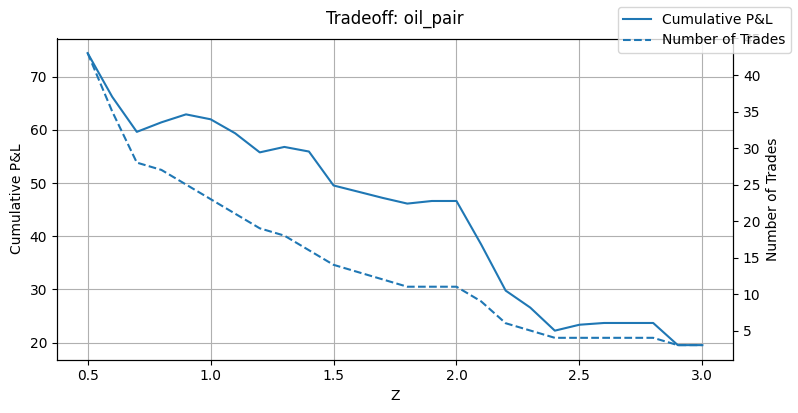

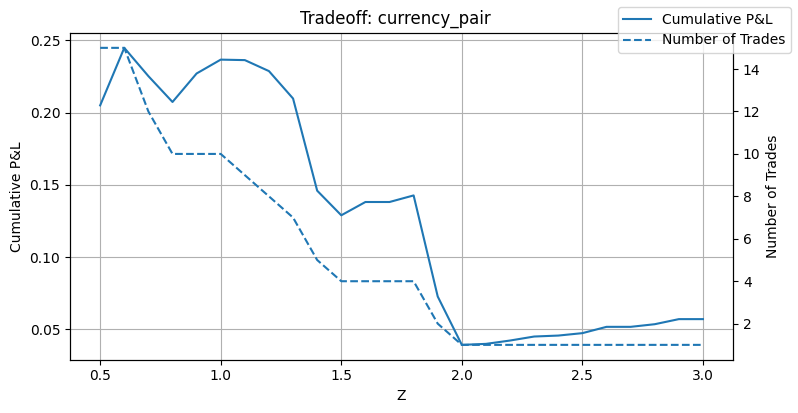

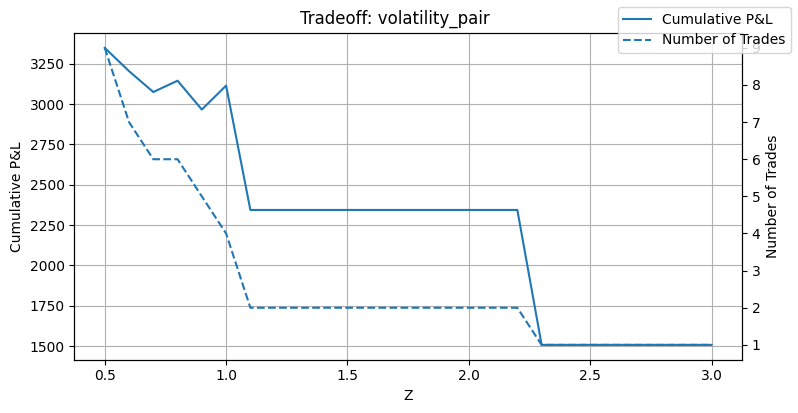

,pair,best_Z,N_trades,cum_PnL,avg_PnL
0,oil_pair,0.5,43,74.4471,1.7313
1,currency_pair,0.6,15,0.2448,0.0163
2,volatility_pair,0.5,9,3348.4355,372.0484


In [12]:
# Use summary + Z* sweep and plots
summary_df, opt_tables = analyze_pairs_nb(
    all_data,
    selected,
    Z_min=0.5, Z_max=3.0, dZ=0.1, cost=0.002
)
summary_df

/home/gusta/projects/cqf_final_exam/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)


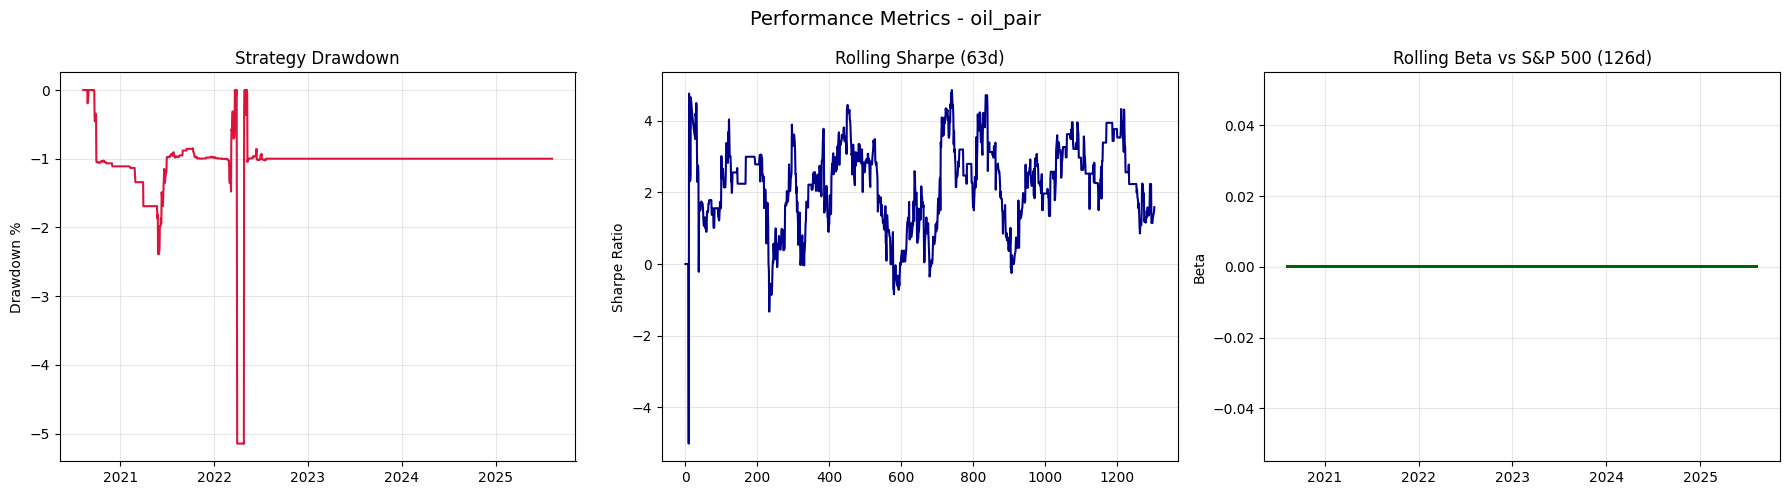

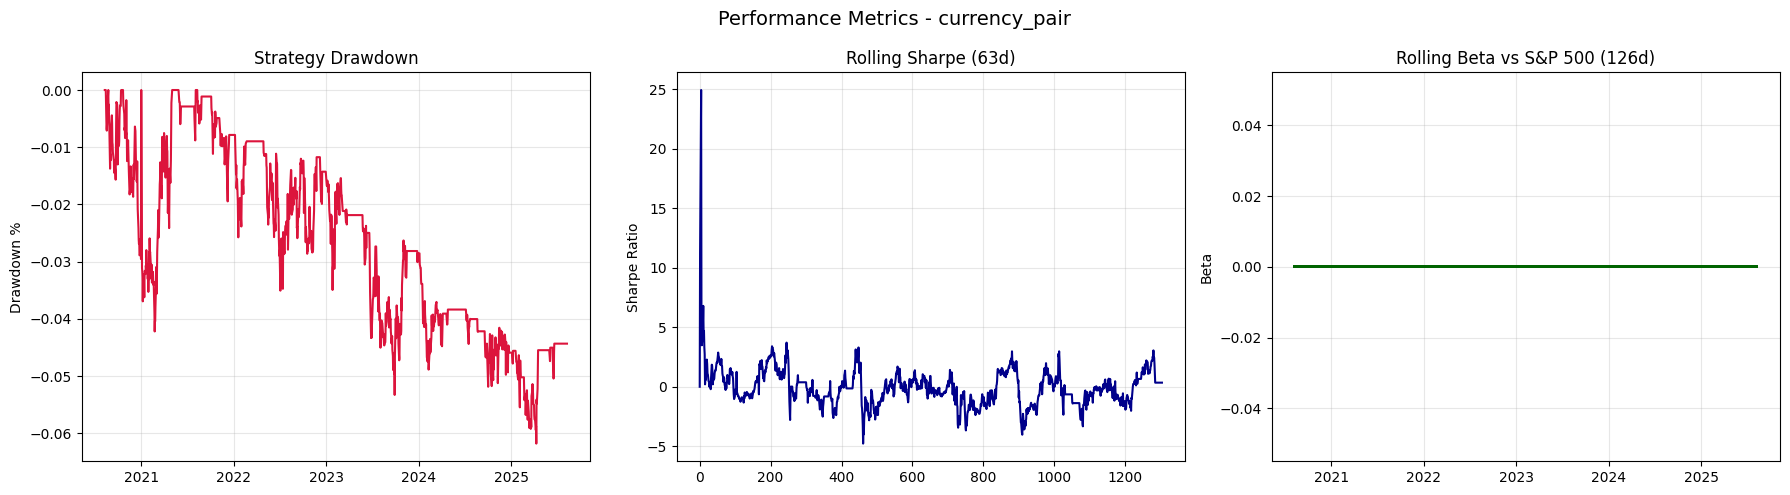

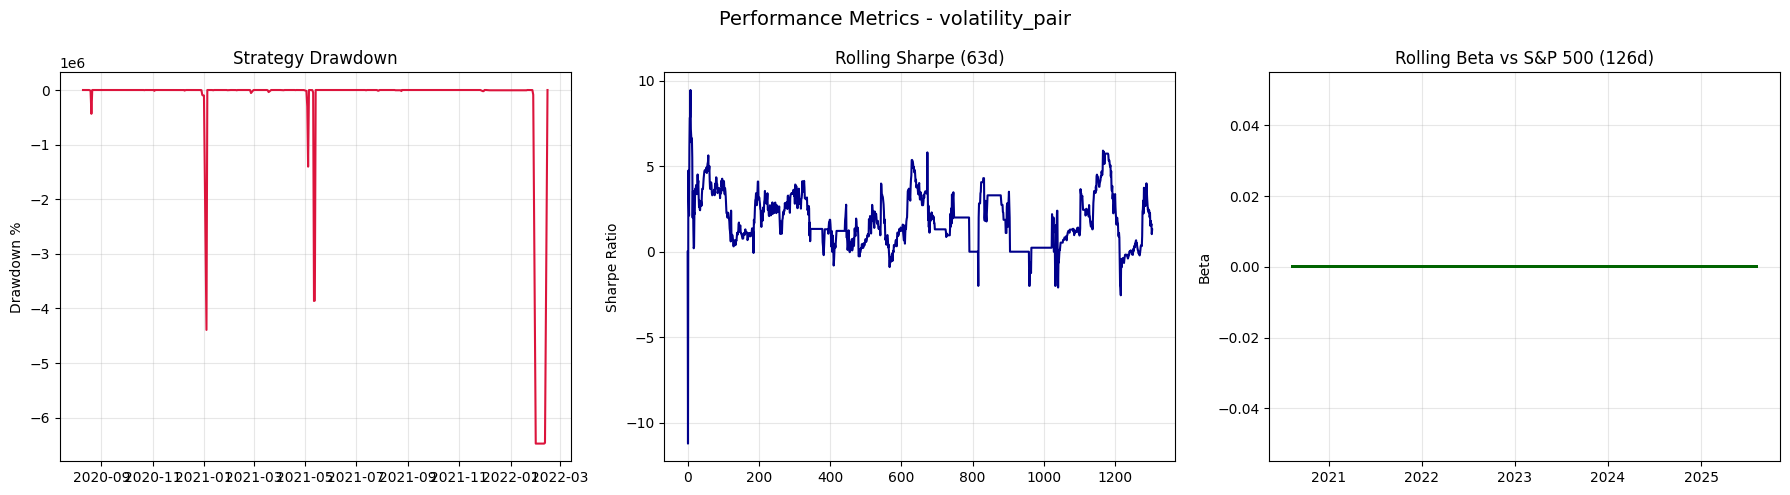

In [13]:
pair_pnl = generate_pair_pnl(
    all_data=all_data,
    summary_df=summary_df,
    selected=selected,
    cost=0.002  # include simple costs
)

# Vectorized plotting using dictionary comprehension and immediate display
plots = {
    pair_name: plot_performance(
        pnl.diff().fillna(0),
        sharpe_window=63,
        beta_window=126,
        pair_name=pair_name
    )
    for pair_name, pnl in pair_pnl.items()
}

# Display all plots
for fig in plots.values():
    plt.show()

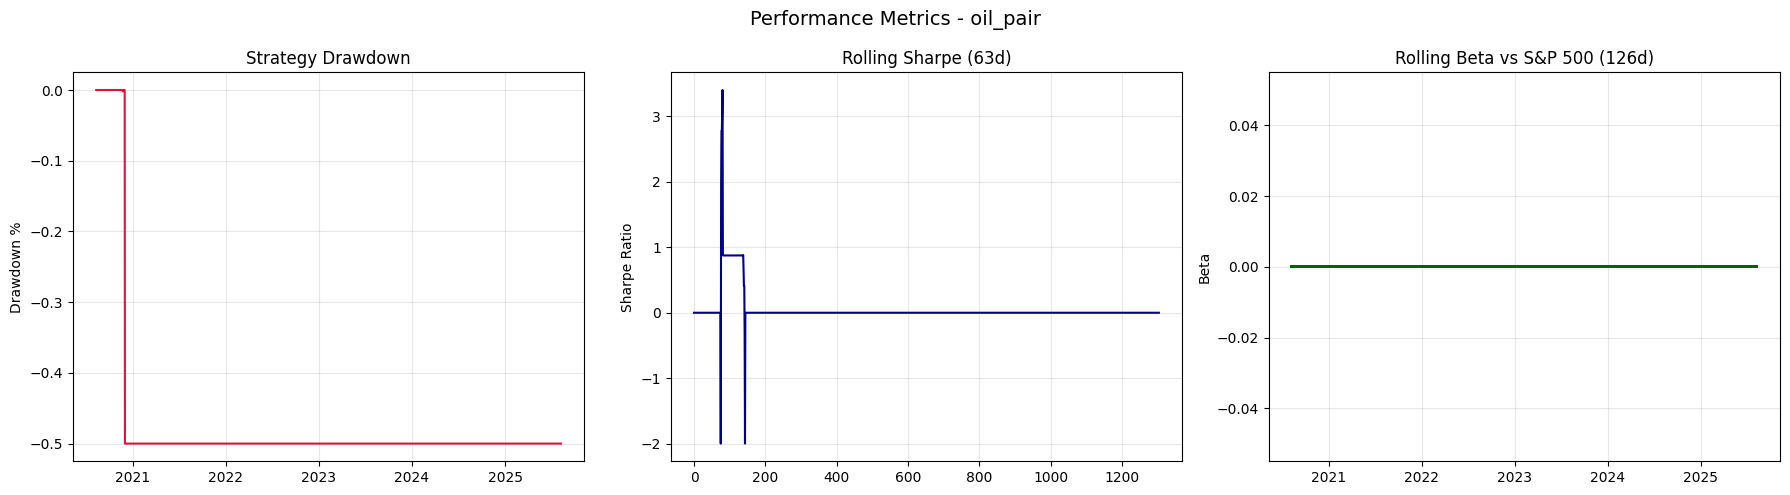

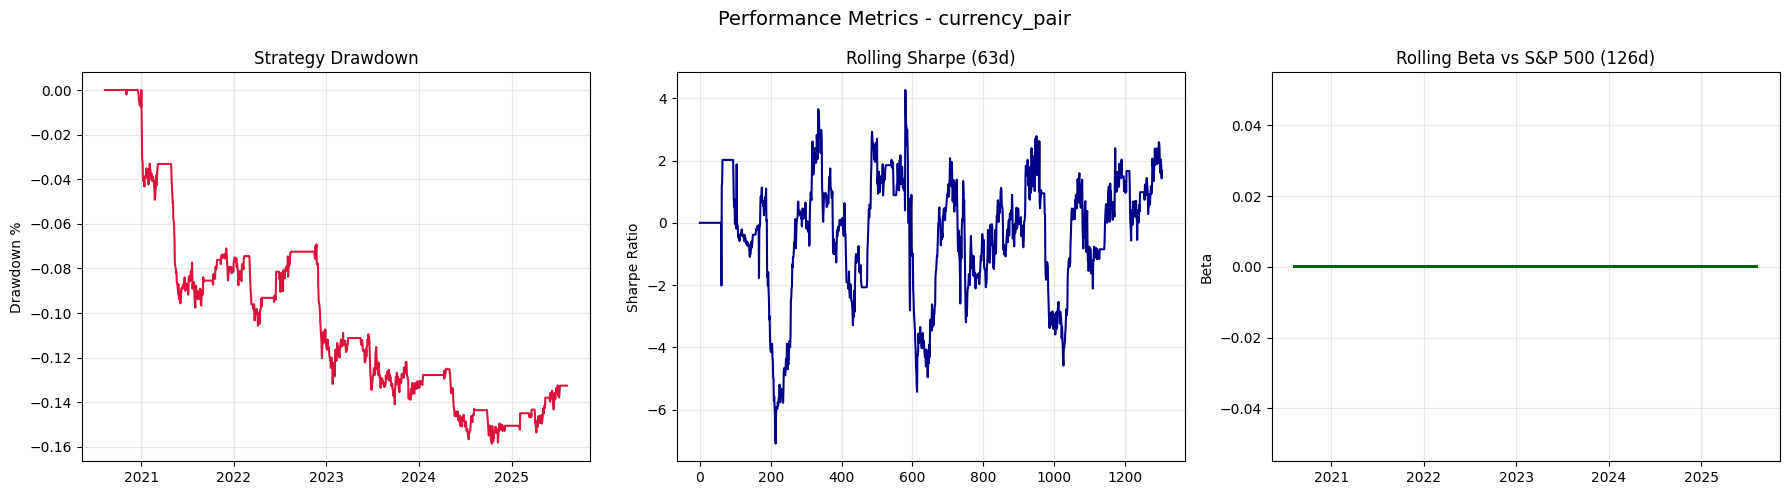

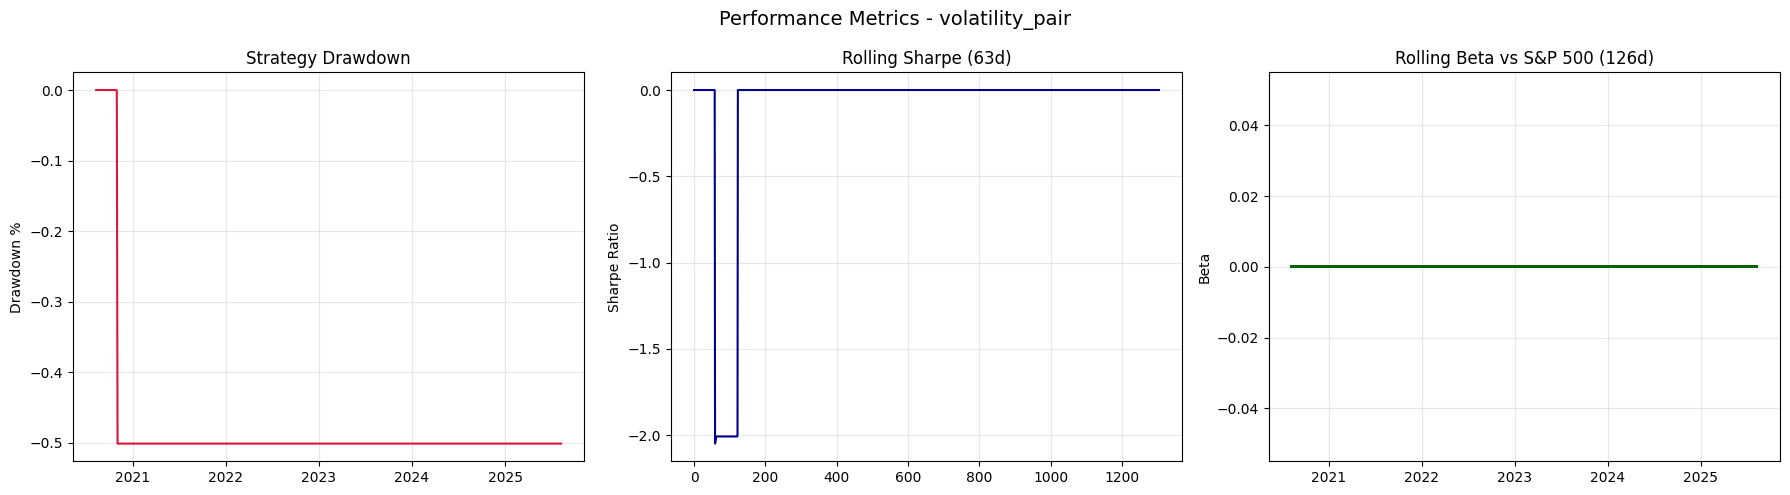

In [14]:
# Guarded backtest with stops for selected pairs
guarded_returns = run_guarded_backtests(selected, all_data, backtest_type='stops')

# Vectorized plotting using dictionary comprehension
plots = {
    pair: plot_performance(guarded_returns[pair].fillna(0), sharpe_window=63, beta_window=126, pair_name=pair)
    for pair in selected if pair in guarded_returns
}

# Display all plots
for fig in plots.values():
    plt.show()

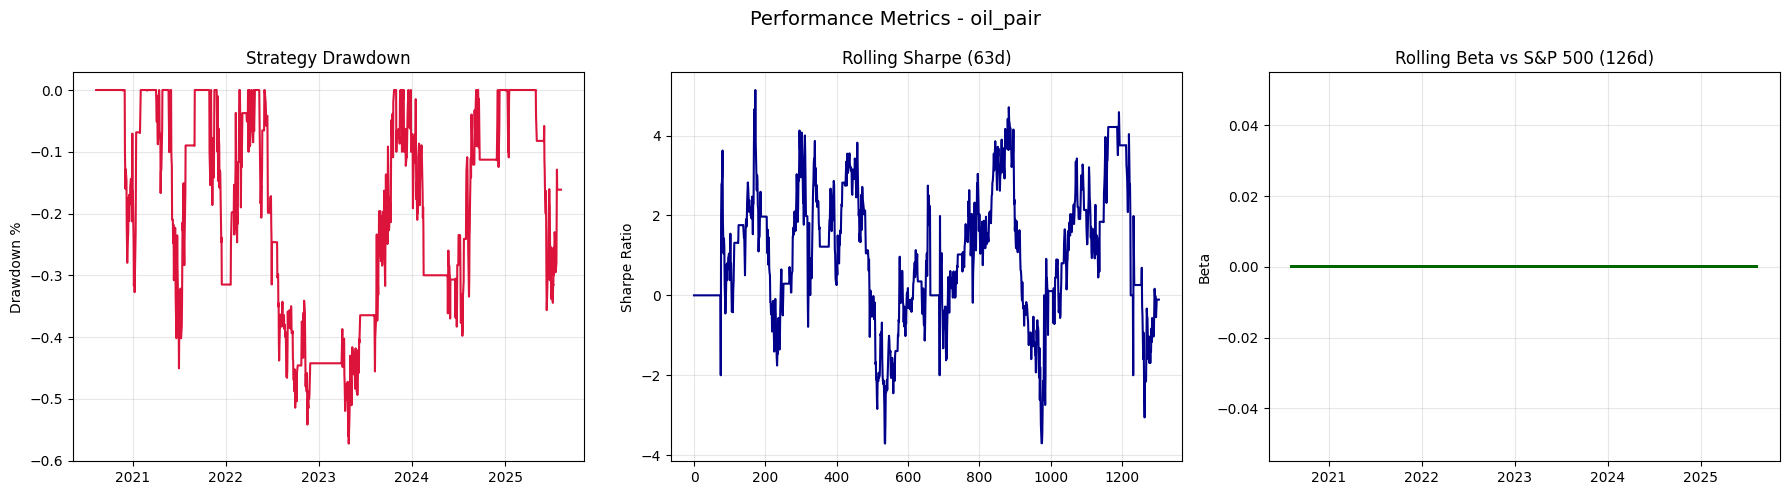

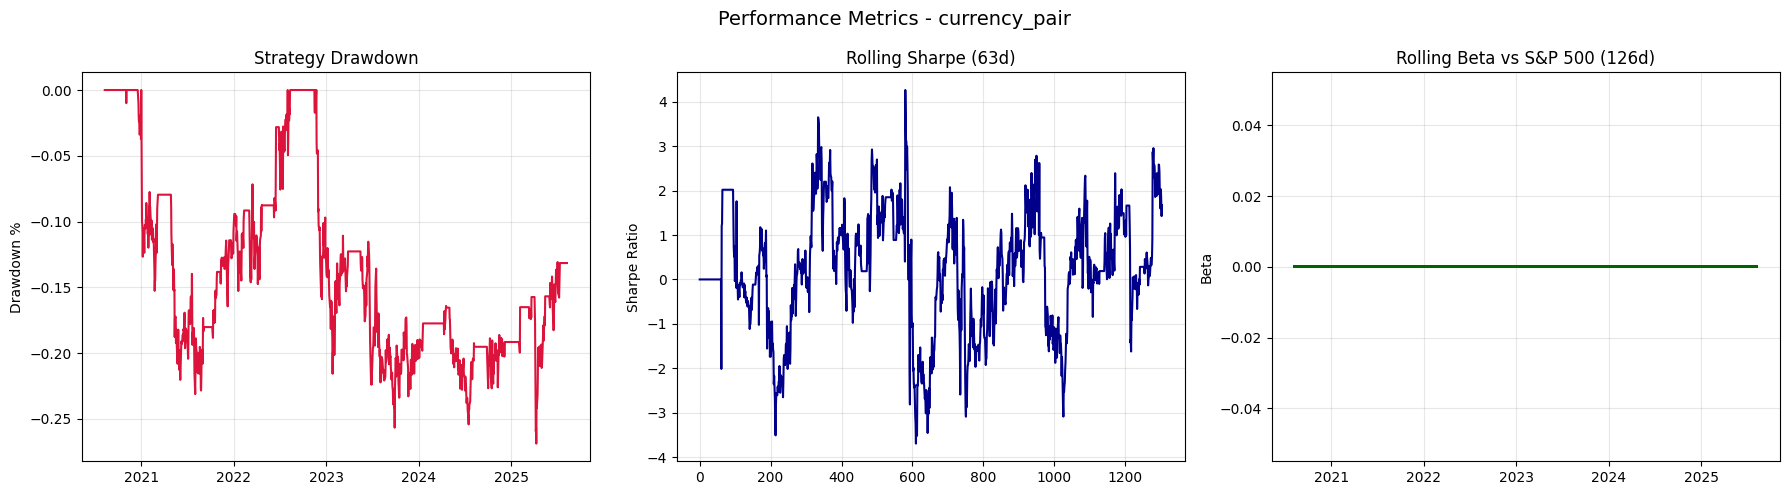

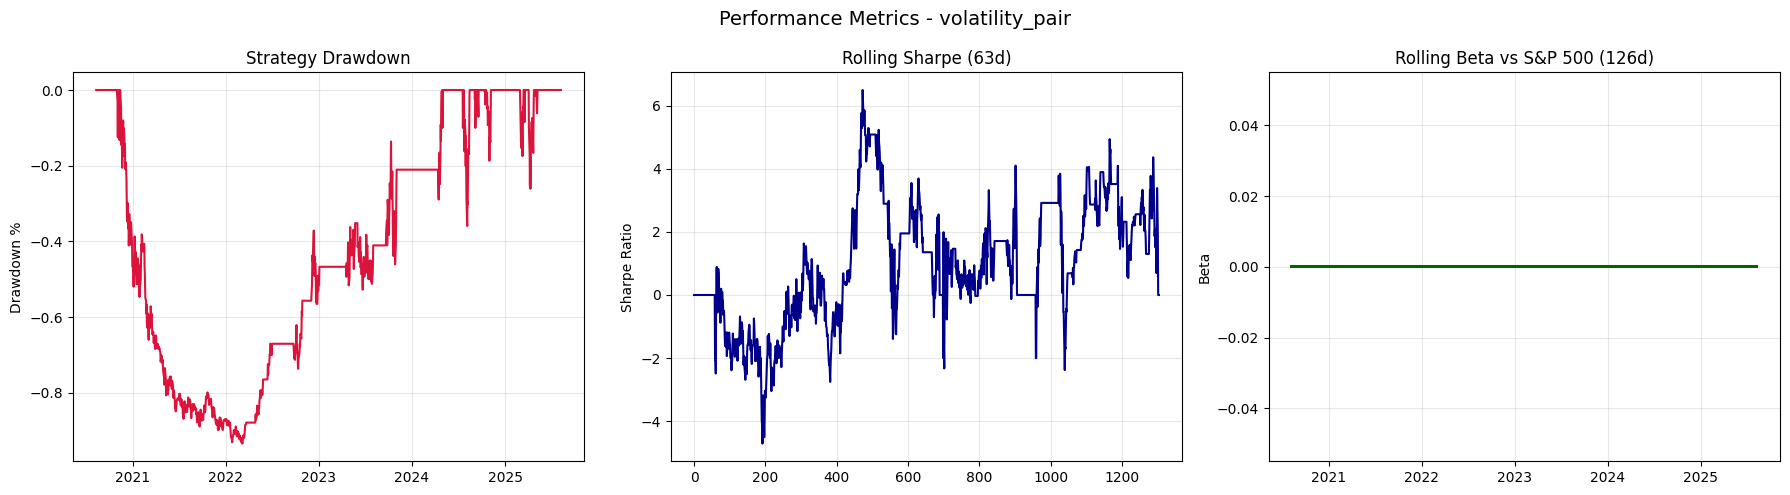

In [15]:
# Vol-targeted backtest with improved risk management parameters
guarded_returns = run_guarded_backtests(selected, all_data, backtest_type='vol_targeted')

# Vectorized plotting using dictionary comprehension
plots = {
    pair: plot_performance(guarded_returns[pair].fillna(0), sharpe_window=63, beta_window=126, pair_name=pair)
    for pair in selected if pair in guarded_returns
}

# Display all plots
for fig in plots.values():
    plt.show()

In [16]:
# Individual pair backtests with stops
guarded_returns = run_individual_pair_backtests(selected, all_data, summary_df)

# Vectorized metrics computation using list comprehension
def get_pair_info(pair_name, summary_df):
    """Extract pair info with error handling"""
    try:
        row = summary_df.loc[summary_df['pair'] == pair_name].iloc[0]
        return {
            'best_Z': row.get('best_Z', np.nan),
            'N_trades': row.get('N_trades', np.nan)
        }
    except (IndexError, KeyError):
        return {}

# Compute metrics for all pairs in one pass
comparison_rows = [
    compute_pair_metrics(
        guarded_returns[pair_name].fillna(0), 
        pair=pair_name, 
        pair_info=get_pair_info(pair_name, summary_df)
    )
    for pair_name in selected 
    if pair_name in guarded_returns
]

metrics_df = pd.DataFrame(comparison_rows)
metrics_df[['pair', 'CAGR', 'Vol_Ann', 'Sharpe', 'Sortino', 'MaxDD', 'MaxDD_Days', 'Calmar', 'best_Z', 'HitRate', 'N']]

,pair,CAGR,Vol_Ann,Sharpe,Sortino,MaxDD,MaxDD_Days,Calmar,best_Z,HitRate,N
0,oil_pair,0.0399,0.2094,0.271,0.059,-0.1567,1243,0.255,0.5,0.0008,1305
1,currency_pair,-0.0075,0.0471,-0.136,-0.1847,-0.0875,1162,-0.0857,0.6,0.4307,1305
2,volatility_pair,0.2934,0.5376,0.7176,0.0976,-0.5,1239,0.5867,0.5,0.0038,1305


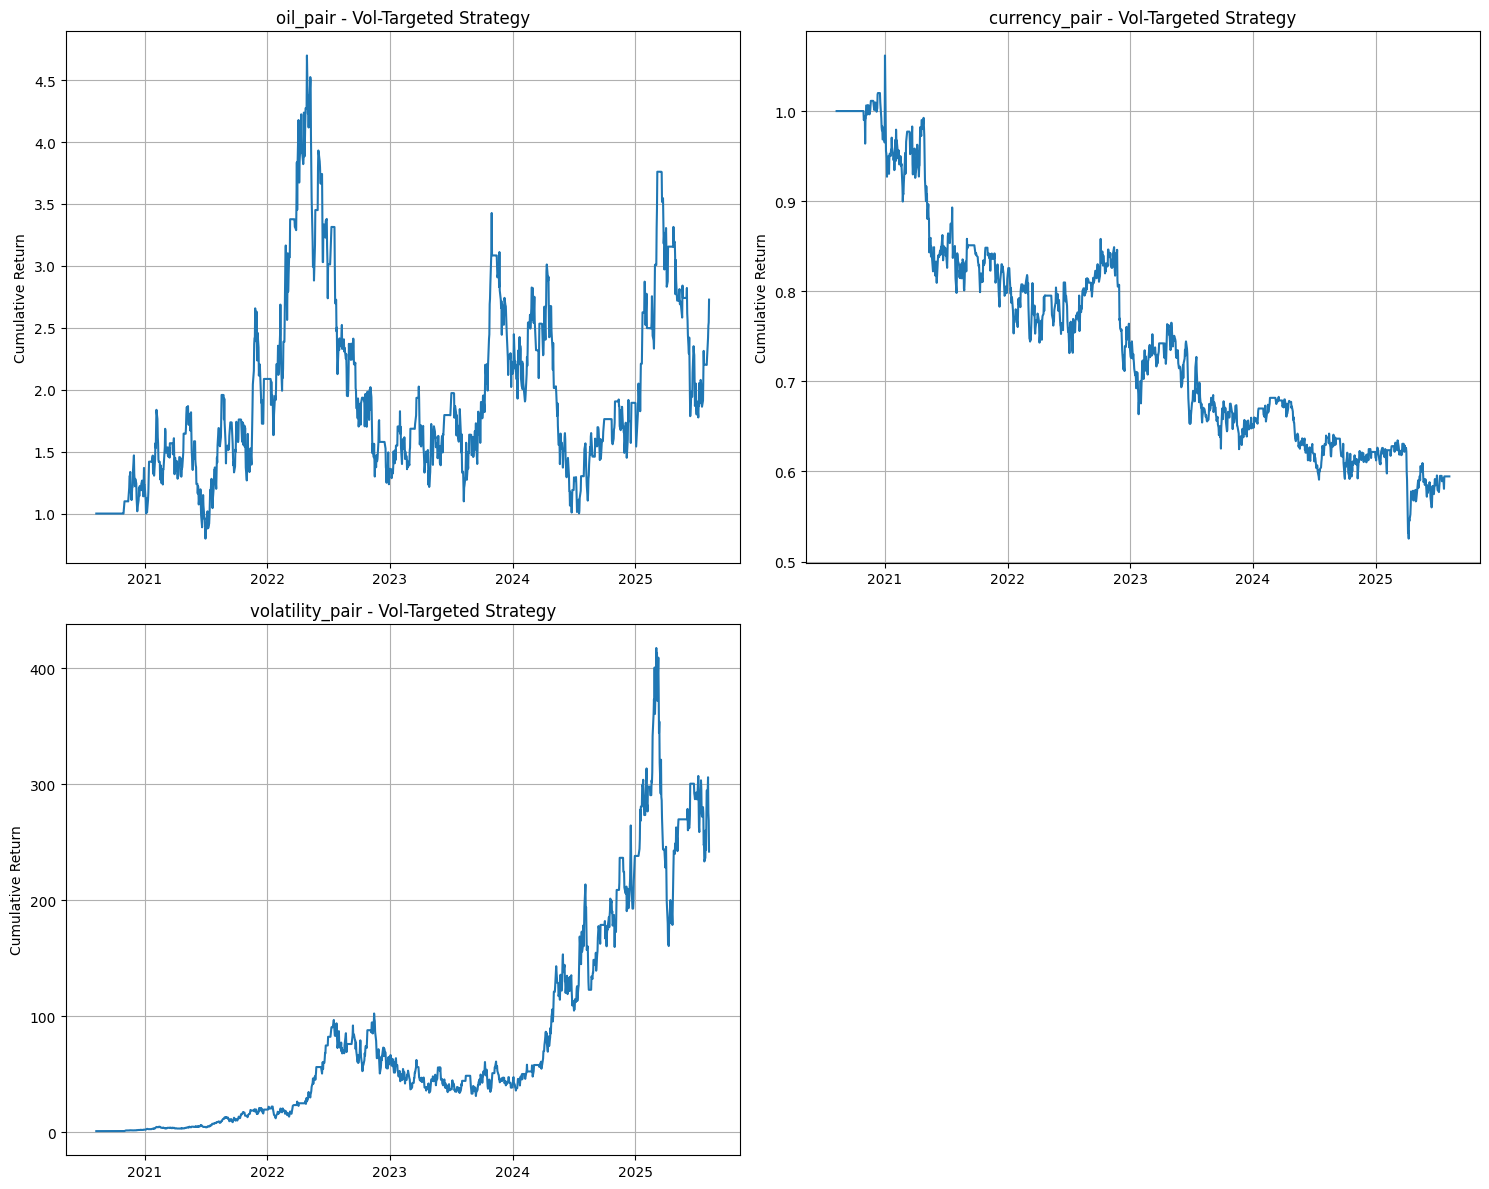

In [17]:
# Vol-targeted backtest for the three selected pairs
guarded_returns = run_vol_targeted_backtests(selected, all_data, summary_df)

# Vectorized plotting using numpy array operations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

# Filter valid pairs and plot using enumerate
valid_pairs = [(i, pair) for i, pair in enumerate(selected) if pair in guarded_returns and i < len(axes)]

for i, pair in valid_pairs:
    cumulative = (1 + guarded_returns[pair]).cumprod()
    axes[i].plot(cumulative.index, cumulative.values)
    axes[i].set_title(f'{pair} - Vol-Targeted Strategy')
    axes[i].set_ylabel('Cumulative Return')
    axes[i].grid(True)

# Hide unused subplots
for j in range(len(valid_pairs), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()